## Project Definition

- With the growing volume of news articles spanning domains such as sports, entertainment, politics, and more, the need for a robust and automated content categorization system has become increasingly critical. Relying on manual efforts to classify such a diverse array of articles is not only resource-intensive but also prone to human error, which can result in reputational risks for the organization.  

- Additionally, manual processes often introduce delays and inconsistencies in content management. To address these challenges and drive operational efficiency, the organization acknowledges the strategic importance of leveraging advanced technologies—particularly machine learning—to automate and improve the accuracy and speed of news article categorization.

- **The task is to analyze the text in news articles and build an unsupervised learning model for categorizing them**.

## Data 

- **Text**: The main body of the news article

## **Installing the necessary libraries**

In [ ]:
!pip install -r requirements.txt

## importing the necessary libraries

In [2]:
# Read and manipulate the data
import pandas as pd
import numpy as np

# Visualise data
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA

# Compute distances
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

# Deep Learning library
import torch
from sentence_transformers import SentenceTransformer

# Cluster the data
from sklearn.cluster import KMeans

# Compute metrics
from sklearn.metrics import classification_report
from sklearn.metrics.cluster import contingency_matrix

# Avoid displaying unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

**Note: Download the dataset from Kaggle: [Kaggle: BBC News Summary](https://www.kaggle.com/datasets/pariza/bbc-news-summary), unzip it, and place it in the project data directory.**

In [3]:
# Define the path to the dataset directory containing categorized news articles
DATA_DIR = os.getcwd() + '/data/BBC News Summary/News Articles'

In [4]:
def load_bbc_articles(news_dir):
    """
    Load BBC news articles from a directory structure into a DataFrame.
    The function assumes the dataset is organized in subdirectories under specified argument,
    where each subdirectory represents a category and contains text files for that category.

    Parameters
    ----------
    news_dir : str
        Path to the main directory containing subdirectories of news articles.

    Returns
    -------
    df : pandas.DataFrame
    category_to_label : dict
        Mapping from category name (str) to integer label (int).
    label_to_category : dict
        Reverse mapping from integer label (int) to category name (str).
    """

    data = []
    categories = sorted([d for d in os.listdir(news_dir) if os.path.isdir(os.path.join(news_dir, d))])
    category_to_label = {category: idx for idx, category in enumerate(categories)}
    label_to_category = {idx: category for category, idx in category_to_label.items()}

    for category in categories:
        print(f"Category: {category}")
        category_path = os.path.join(news_dir, category)
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            try:
                with open(file_path, 'r', encoding='latin-1') as f:
                    text = f.read().strip()
                data.append({
                    'Text': text,
                    'Label': category,
                    'Label_ID': category_to_label[category]
                })
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    df = pd.DataFrame(data)
    return df, category_to_label, label_to_category

In [5]:
# Load BBC news articles and their corresponding labels
articles_df, category_to_label, label_to_category = load_bbc_articles(DATA_DIR)

# Display the first 10 rows of the DataFrame to get a quick preview of the data
articles_df.head(10)

Category: business
Category: entertainment
Category: politics
Category: sport
Category: tech


,Text,Label,Label_ID
0,UK economy facing 'major risks'\n\nThe UK manu...,business,0
1,Aids and climate top Davos agenda\n\nClimate c...,business,0
2,Asian quake hits European shares\n\nShares in ...,business,0
3,India power shares jump on debut\n\nShares in ...,business,0
4,Lacroix label bought by US firm\n\nLuxury good...,business,0
5,Insurance bosses plead guilty\n\nAnother three...,business,0
6,Turkey-Iran mobile deal 'at risk'\n\nTurkey's ...,business,0
7,"Parmalat to return to stockmarket\n\nParmalat,...",business,0
8,WorldCom director admits lying\n\nThe former c...,business,0
9,Ebbers denies WorldCom fraud\n\nFormer WorldCo...,business,0


In [6]:
# Print the shape of the DataFrame
articles_df.shape

(2225, 3)

### Checking for missing values

In [7]:
# Check for any missing/null values in the dataset
articles_df.isnull().sum()

Text        0
Label       0
Label_ID    0
dtype: int64

### Checking for duplicate values

In [8]:
# Check for duplicate entries in the dataset
articles_df.duplicated().sum()

98

- **We'll drop the duplicate values in the data.**

In [9]:
# Drop duplicate rows from the DataFrame to ensure data quality
articles_df = articles_df.drop_duplicates()

# Reset the index after dropping duplicates for a clean and continuous index
articles_df.reset_index(drop=True, inplace=True)

# Re check for duplicates after cleanup to confirm none remain
articles_df.duplicated().sum()

0

## **Model Building**

- The **all-MiniLM-L6-v2** model is an all-round (**all**) model trained on a large and diverse dataset of over 1 billion training samples and generates state-of-the-art sentence embeddings of 384 dimensions.

In [10]:
# Load a pre-trained SentenceTransformer model for generating sentence embeddings.
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

### **Encoding the dataset**

In [11]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Generate embeddings for all news articles in the DataFrame.
# This creates a dense vector representation for each article
article_embeddings = model.encode(articles_df['Text'].tolist(), show_progress_bar=True, device=device)

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

In [13]:
# Print the shape of the generated embedding matrix
article_embeddings.shape

(2127, 384)

## **Semantic Search**

**Let's search for similar reviews in our dataset.**

In [14]:
# defining a function to find the top k similar sentences for a given query
def top_k_similar_sentences(article_embeddings, query_text, k):
    """
    Retrieve the top k most similar news articles to a given query based on cosine similarity.

    Parameters
    ----------
    article_embeddings : np.ndarray
        The matrix of sentence embeddings for all articles in the dataset.

    query_text : str
        The input query/article for which similar articles need to be found.

    k : int
        The number of top similar articles to retrieve.

    Returns
    -------
    pandas.Series
        A series of the top k most similar article texts from the dataset.
    """

    # Encode the query text into a dense vector
    query_embedding = model.encode(query_text)

    # Compute cosine similarity between the query embedding and all article embeddings
    similarity_scores = np.dot(article_embeddings, query_embedding)

    # Get indices of the top-k articles with highest similarity scores
    top_k_article_indices = np.argsort(similarity_scores)[::-1][:k]

    # Return the top k article texts
    return articles_df.loc[list(top_k_article_indices), 'Text']

In [15]:
# Define the input query for which we want to find similar news articles
query_text = "Quarterly profits at US media giant TimeWarner"

# Retrieve the top 5 most similar articles to the query
top_k_reviews = top_k_similar_sentences(article_embeddings, query_text, 5)

# Display the retrieved articles with spacing for readability
for i in top_k_reviews:
    print(i, end="\n\n")

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AO

## **Categorization**

**Use K-Means Clustering to categorize the data.**

In [16]:
# List to store mean distortion values for each number of clusters
mean_distortions = []

# Define the range of cluster numbers to evaluate
clusters = range(2, 11)

# Iterate over the range of cluster values to compute distortions
for num_clusters in clusters:
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)

    # Fit KMeans on the article embeddings
    kmeans.fit(article_embeddings)

    # Compute distortion
    distortion = sum(np.min(cdist(article_embeddings, kmeans.cluster_centers_, "euclidean"), axis=1) ** 2)

    # Store the distortion value
    mean_distortions.append(distortion)

    # Print the number of clusters and corresponding distortion
    print(f"Clusters: {num_clusters}, Distortion: {distortion:.2f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Clusters: 2, Distortion: 1795.31
Clusters: 3, Distortion: 1721.39
Clusters: 4, Distortion: 1667.04
Clusters: 5, Distortion: 1621.50
Clusters: 6, Distortion: 1598.41
Clusters: 7, Distortion: 1584.66
Clusters: 8, Distortion: 1553.90
Clusters: 9, Distortion: 1549.66
Clusters: 10, Distortion: 1519.54


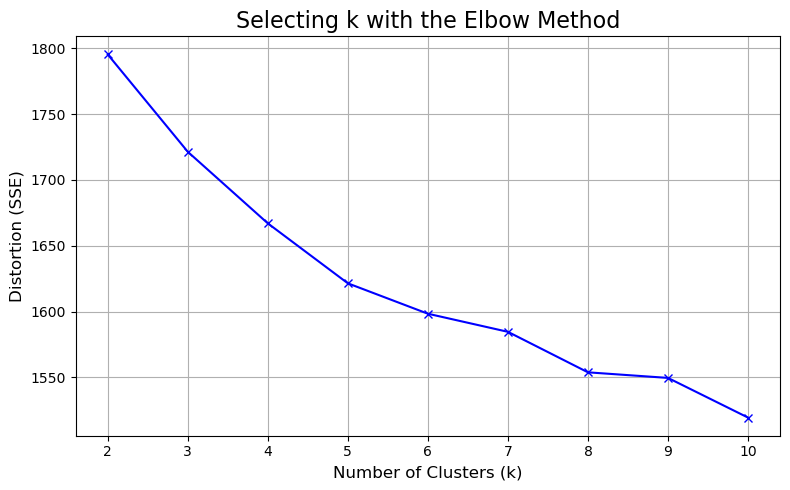

In [17]:
# Create a new figure with a defined size
plt.figure(figsize=(8, 5))

# Plot the distortion values against the number of clusters
plt.plot(clusters, mean_distortions, "bx-")

# Label the x-axis to indicate it represents the number of clusters (k)
plt.xlabel("Number of Clusters (k)", fontsize=12)

# Label the y-axis to indicate it represents the distortion (SSE)
plt.ylabel("Distortion (SSE)", fontsize=12)

# Set the title of the plot
plt.title("Selecting k with the Elbow Method", fontsize=16)

# Add gridlines for better readability
plt.grid(True)

# Adjust layout to prevent clipping of labels/titles
plt.tight_layout()

# Display the plot
plt.show()

**Check the silhouette scores.**

In [18]:
# Initialize an empty list to store silhouette scores
sil_scores = []

# Iterate over the range of cluster values to compute silhouette
for num_clusters in clusters:
    # Initialize KMeans with the current number of clusters
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)

    # Fit the KMeans model to the embedding matrix and predict the cluster labels
    labels = kmeans.fit_predict(article_embeddings)

    # Compute the silhouette score for the current clustering configuration
    score = silhouette_score(article_embeddings, labels)

    # Append the silhouette score to the list
    sil_scores.append(score)

    # Print the number of clusters and corresponding silhouette
    print(f"Clusters: {num_clusters}, Silhouette Score: {score:.5f}")

Clusters: 2, Silhouette Score: 0.04681
Clusters: 3, Silhouette Score: 0.05041
Clusters: 4, Silhouette Score: 0.05829
Clusters: 5, Silhouette Score: 0.06730
Clusters: 6, Silhouette Score: 0.06424
Clusters: 7, Silhouette Score: 0.05808
Clusters: 8, Silhouette Score: 0.05740
Clusters: 9, Silhouette Score: 0.05845
Clusters: 10, Silhouette Score: 0.05670


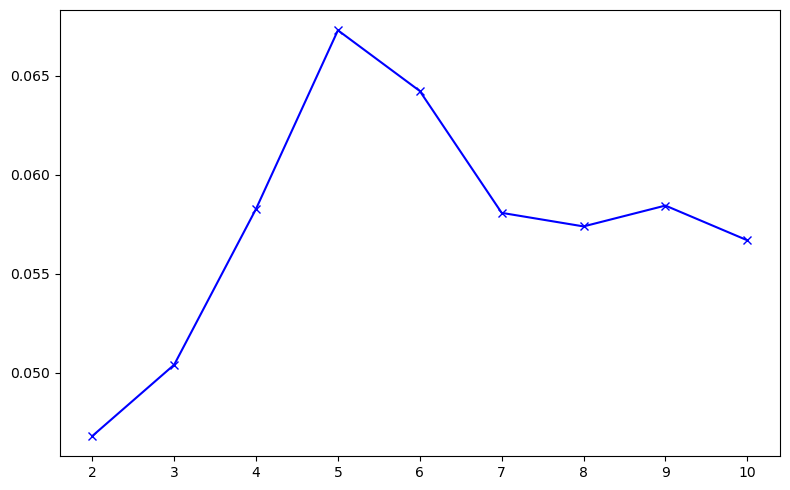

In [19]:
# Create a new figure with a defined size
plt.figure(figsize=(8, 5))

# Plot the silhouette values against the number of clusters
plt.plot(clusters, sil_scores, "bx-")

# Adjust layout to prevent clipping of labels/titles
plt.tight_layout()

# Display the plot
plt.show()

In [20]:
# Set the optimal number of clusters
optimal_clusters = 5

# Initialize the KMeans algorithm with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=1).fit(article_embeddings)

In [21]:
# Create a copy of the original DataFrame
clustered_data = articles_df.copy()

# Assign the cluster labels obtained from the KMeans algorithm to the new category column
clustered_data['Category'] = kmeans.labels_

# Display the first few rows of the DataFrame
clustered_data.head()

,Text,Label,Label_ID,Category
0,UK economy facing 'major risks'\n\nThe UK manu...,business,0,2
1,Aids and climate top Davos agenda\n\nClimate c...,business,0,3
2,Asian quake hits European shares\n\nShares in ...,business,0,2
3,India power shares jump on debut\n\nShares in ...,business,0,2
4,Lacroix label bought by US firm\n\nLuxury good...,business,0,2


In [22]:
# Print the contingency table to show the relationship between true labels and predicted categories
print("Contingency Table:\n")

# Print contingency table to compare the actual labels with the predicted clusters
print(pd.crosstab(clustered_data['Label'], clustered_data['Category']))

Contingency Table:

Category         0    1    2    3    4
Label                                 
business        17    2  470   12    2
entertainment   14    0    3    2  350
politics         4    3   11  384    1
sport            0  501    0    1    3
tech           332    3    2    0   10


In [23]:
# Convert the true labels from the DataFrame Label_ID into a numpy array
true_labels = articles_df['Label_ID'].to_numpy()

# Get the predicted cluster labels from the KMeans model
predicted_clusters = kmeans.labels_

# Compute the contingency matrix to compare true labels and predicted clusters
cont_matrix = contingency_matrix(true_labels, predicted_clusters)

# For each cluster get the true label
cluster_to_true_label = np.argmax(cont_matrix, axis=0)

# Create a mapping from each cluster to the corresponding true label
category_dict = {
    cluster_id: label_to_category[true_label_id]
    for cluster_id, true_label_id in enumerate(cluster_to_true_label)
}

## **PCA Plot for Cluster Visualization**

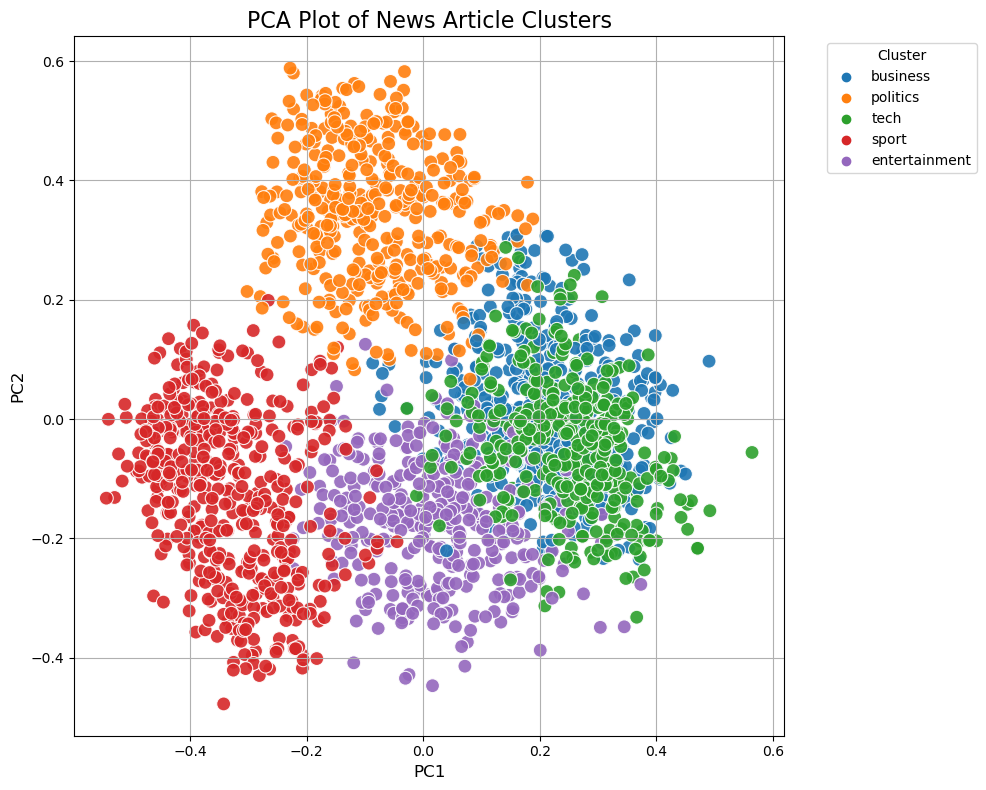

In [24]:
# Reduce the dimensionality of the embedding matrix
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(article_embeddings)

# Create a DataFrame to store the 2D PCA coordinates and cluster labels
pca_df = pd.DataFrame({
    'PC1': embedding_2d[:, 0],
    'PC2': embedding_2d[:, 1],
    'Cluster': clustered_data['Category'].replace(category_dict)
})

# Visualize the clusters using a scatter plot
plt.figure(figsize=(10, 8))
# Use seaborn's scatterplot to plot PC1 vs PC2, with points colored by cluster
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=100, alpha=0.9)
plt.title('PCA Plot of News Article Clusters', fontsize=16)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
# Add legend and position it outside the plot for clarity
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
# Adjust layout to prevent clipping
plt.tight_layout()
# Display the plot
plt.show()

## **Comparing with Actual Categories**

In [25]:
# Apply the category_dict mapping to replace the numeric cluster labels with the actual category labels
clustered_data['Category'] = clustered_data['Category'].replace(category_dict)

In [26]:
# Print the classification report which provides a detailed evaluation of the classification performance
print(classification_report(clustered_data['Label'], clustered_data['Category']))

               precision    recall  f1-score   support

     business       0.97      0.93      0.95       503
entertainment       0.96      0.95      0.95       369
     politics       0.96      0.95      0.96       403
        sport       0.98      0.99      0.99       505
         tech       0.90      0.96      0.93       347

     accuracy                           0.96      2127
    macro avg       0.95      0.96      0.96      2127
 weighted avg       0.96      0.96      0.96      2127



## **Validate Incorrect Predictions**

In [27]:
# Create a new DataFrame containing only the rows where the predicted category does not match the actual label
wrong_category_data = clustered_data[clustered_data['Label'] != clustered_data['Category']].copy()

# Show the shape of the resulting DataFrame to get the number of misclassified samples
wrong_category_data.shape

(90, 4)

In [28]:
# Display the first few rows of the DataFrame
wrong_category_data.head(10)

,Text,Label,Label_ID,Category
1,Aids and climate top Davos agenda\n\nClimate c...,business,0,politics
21,Iraq to invite phone licence bids\n\nIraq is t...,business,0,tech
68,Golden rule 'intact' says ex-aide\n\nChancello...,business,0,politics
82,Brussels raps mobile call charges\n\nThe Europ...,business,0,tech
170,Ad sales boost Time Warner profit\n\nQuarterly...,business,0,tech
209,Crossrail link 'to get go-ahead'\n\nThe Â£10bn...,business,0,politics
225,Electronics firms eye plasma deal\n\nConsumer ...,business,0,tech
226,Orange colour clash set for court\n\nA row ove...,business,0,tech
229,Vodafone appoints new Japan boss\n\nVodafone h...,business,0,tech
249,Ban on forced retirement under 65\n\nEmployers...,business,0,politics


## **Conclusion**

**Model Performance**

- The model can correctly categorize 96% of the news articles.
- It generates around ~90 wrong predictions on a dataset of ~2225 articles.

**Improvements using Multi Label Categorization**

- We can try tagging news articles with more than one category for better categorization. 
- One approach is to identify the cluster centers closest to each news article and assign one or more categories accordingly.